In [1]:
!pip install wandb

In [2]:
import wandb

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nipkha21 (nipkha21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data_utils import create_data_loaders, get_data_statistics
from models import SimpleMLP, get_model
from training_utils import ModelTrainer, EarlyStopping, get_optimizer, get_scheduler
from evaluation import ModelEvaluator

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import wandb
from tqdm import tqdm
import time

In [10]:
class MLPFacialExpressionDataset(Dataset):
    def __init__(self, data, transform=None, is_test=False):
        self.data = data
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        image = np.array([int(pixel) for pixel in pixels.split()], dtype=np.float32)
        image = image / 255.0
        image = torch.FloatTensor(image)

        if self.is_test:
            return image
        else:
            emotion = int(self.data.iloc[idx]['emotion'])
            return image, emotion

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
train_path='drive/MyDrive/train.csv'
train_df = pd.read_csv(train_path)

In [13]:
print(f"Training set: {train_df.shape}")

Training set: (28709, 2)


In [14]:
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [15]:
from data_utils import (
        load_split_data,
        get_transforms
    )

In [16]:
from models import SimpleMLP, get_model

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, experiment_name, run_name, device='cuda'):

    wandb.init(
        project="facial-expression-recognition",
        group=experiment_name,
        name=run_name,
        config={
            "data_split_method": "predefined_stratified",
            "train_samples": len(train_loader.dataset),
            "val_samples": len(val_loader.dataset),
            "split_random_state": 42,
            "model": "baseline_mlp"
        },
        reinit=True
    )

    wandb.watch(model, log='all')

    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_state = None

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

            current_acc = 100. * train_correct / train_total
            pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{current_acc:.2f}%'})

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100. * train_correct / train_total
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * val_correct / val_total

        current_lr = optimizer.param_groups[0]['lr']
        if scheduler:
            scheduler.step()

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': epoch_train_loss,
            'train_accuracy': epoch_train_acc,
            'val_loss': epoch_val_loss,
            'val_accuracy': epoch_val_acc,
            'learning_rate': current_lr
        })

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print(f"  Learning Rate: {current_lr:.6f}")
        print("-" * 50)

    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.2f}%")

    wandb.finish()
    return model, history

In [18]:
wandb.login()

print("=== LOADING PRE-SPLIT DATA ===")

train_df, val_df, test_df = load_split_data('drive/MyDrive/data')

emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

=== LOADING PRE-SPLIT DATA ===


In [19]:
print("=== DATA PREPROCESSING EXPERIMENTS ===")

wandb.init(
    project="facial-expression-recognition",
    group="MLP_Training",
    name="MLP_Data_Cleaning",
    config={
        "data_split_method": "predefined_stratified",
        "train_samples": len(train_df),
        "val_samples": len(val_df),
        "experiment_type": "data_preprocessing"
    },
    reinit=True
)

batch_sizes = [16, 32, 64, 128]
preprocessing_results = {}

for batch_size in batch_sizes:
    print(f"\nTesting batch size: {batch_size}")

    train_dataset = MLPFacialExpressionDataset(train_df)
    val_dataset = MLPFacialExpressionDataset(val_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    start_time = time.time()
    for i, (data, target) in enumerate(train_loader):
        if i >= 10:
            break
    loading_time = time.time() - start_time

    preprocessing_results[batch_size] = {
        'loading_time': loading_time,
        'batches_per_epoch': len(train_loader),
        'memory_per_batch': data.element_size() * data.nelement() / (1024**2)
    }

    print(f"  Loading time (10 batches): {loading_time:.2f}s")
    print(f"  Batches per epoch: {len(train_loader)}")
    print(f"  Memory per batch: {preprocessing_results[batch_size]['memory_per_batch']:.2f} MB")

for batch_size, results in preprocessing_results.items():
    wandb.log({
        f'batch_size_{batch_size}_loading_time': results['loading_time'],
        f'batch_size_{batch_size}_batches_per_epoch': results['batches_per_epoch'],
        f'batch_size_{batch_size}_memory_mb': results['memory_per_batch']
    })

wandb.finish()

=== DATA PREPROCESSING EXPERIMENTS ===


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



Testing batch size: 16
  Loading time (10 batches): 0.31s
  Batches per epoch: 1256
  Memory per batch: 0.14 MB

Testing batch size: 32
  Loading time (10 batches): 0.32s
  Batches per epoch: 628
  Memory per batch: 0.28 MB

Testing batch size: 64
  Loading time (10 batches): 0.54s
  Batches per epoch: 314
  Memory per batch: 0.56 MB

Testing batch size: 128
  Loading time (10 batches): 1.08s
  Batches per epoch: 157
  Memory per batch: 1.12 MB


batch_size_128_batches_per_epoch,▁
batch_size_128_loading_time,▁
batch_size_128_memory_mb,▁
batch_size_16_batches_per_epoch,▁
batch_size_16_loading_time,▁
batch_size_16_memory_mb,▁
batch_size_32_batches_per_epoch,▁
batch_size_32_loading_time,▁
batch_size_32_memory_mb,▁
batch_size_64_batches_per_epoch,▁
batch_size_64_loading_time,▁


In [20]:
print("=== CROSS-VALIDATION SETUP ===")

wandb.init(
    project="facial-expression-recognition",
    group="MLP_Training",
    name="MLP_Cross_Validation",
    config={
        "data_split_method": "predefined_stratified",
        "cv_folds": 5,
        "cv_on_train_only": True
    },
    reinit=True
)

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

cv_results = []
fold_models = []

print(f"Starting {k_folds}-fold cross-validation on training data only...")

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['emotion'])):
    print(f"\n=== Fold {fold + 1}/{k_folds} ===")

    fold_train_data = train_df.iloc[train_idx].reset_index(drop=True)
    fold_val_data = train_df.iloc[val_idx].reset_index(drop=True)

    fold_train_dataset = MLPFacialExpressionDataset(fold_train_data)
    fold_val_dataset = MLPFacialExpressionDataset(fold_val_data)

    fold_train_loader = DataLoader(fold_train_dataset, batch_size=64, shuffle=True)
    fold_val_loader = DataLoader(fold_val_dataset, batch_size=64, shuffle=False)

    model = SimpleMLP(input_size=2304, hidden_size=512, num_classes=7, dropout_rate=0.5)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 20
    best_val_acc = 0.0
    fold_history = {'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0

        for data, targets in fold_train_loader:
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, targets in fold_val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        fold_history['train_acc'].append(train_acc)
        fold_history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    cv_results.append({
        'fold': fold + 1,
        'best_val_acc': best_val_acc,
        'final_train_acc': fold_history['train_acc'][-1],
        'final_val_acc': fold_history['val_acc'][-1]
    })

    fold_models.append(model.state_dict().copy())

    print(f"Fold {fold + 1} - Best Val Acc: {best_val_acc:.2f}%")

    wandb.log({
        f'fold_{fold+1}_best_val_acc': best_val_acc,
        f'fold_{fold+1}_final_train_acc': fold_history['train_acc'][-1],
        f'fold_{fold+1}_final_val_acc': fold_history['val_acc'][-1]
    })

cv_accuracies = [result['best_val_acc'] for result in cv_results]
mean_cv_acc = np.mean(cv_accuracies)
std_cv_acc = np.std(cv_accuracies)

print(f"\n=== Cross-Validation Results ===")
print(f"Mean CV Accuracy: {mean_cv_acc:.2f} ± {std_cv_acc:.2f}%")
print(f"Individual fold accuracies: {cv_accuracies}")

wandb.log({
    'cv_mean_accuracy': mean_cv_acc,
    'cv_std_accuracy': std_cv_acc,
    'cv_min_accuracy': min(cv_accuracies),
    'cv_max_accuracy': max(cv_accuracies)
})

wandb.finish()

=== CROSS-VALIDATION SETUP ===


Starting 5-fold cross-validation on training data only...

=== Fold 1/5 ===
Fold 1 - Best Val Acc: 33.39%

=== Fold 2/5 ===
Fold 2 - Best Val Acc: 34.93%

=== Fold 3/5 ===
Fold 3 - Best Val Acc: 33.76%

=== Fold 4/5 ===
Fold 4 - Best Val Acc: 31.40%

=== Fold 5/5 ===
Fold 5 - Best Val Acc: 33.44%

=== Cross-Validation Results ===
Mean CV Accuracy: 33.39 ± 1.14%
Individual fold accuracies: [33.39139089325703, 34.934063199800946, 33.764618064195076, 31.40084598158746, 33.44115451604877]


cv_max_accuracy,▁
cv_mean_accuracy,▁
cv_min_accuracy,▁
cv_std_accuracy,▁
fold_1_best_val_acc,▁
fold_1_final_train_acc,▁
fold_1_final_val_acc,▁
fold_2_best_val_acc,▁
fold_2_final_train_acc,▁
fold_2_final_val_acc,▁
fold_3_best_val_acc,▁


In [23]:
print("=== HYPERPARAMETER TUNING ===")

hyperparameter_grid = {
    'hidden_size': [256, 512, 1024],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.001, 0.0001, 0.01],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'batch_size': [32, 64, 128]
}

import itertools
import random

all_combinations = list(itertools.product(*hyperparameter_grid.values()))
num_experiments = 10
sampled_combinations = random.sample(all_combinations, min(num_experiments, len(all_combinations)))

hyperparameter_results = []

for i, (hidden_size, dropout_rate, lr, opt_name, batch_size) in enumerate(sampled_combinations):
    print(f"\n=== Hyperparameter Experiment {i+1}/{len(sampled_combinations)} ===")
    print(f"Hidden Size: {hidden_size}, Dropout: {dropout_rate}, LR: {lr}, Optimizer: {opt_name}, Batch Size: {batch_size}")

    wandb.init(
        project="facial-expression-recognition",
        group="MLP_Training",
        name=f"MLP_Hyperparameter_Tuning_exp_{i+1}",
        config={
            'hidden_size': hidden_size,
            'dropout_rate': dropout_rate,
            'learning_rate': lr,
            'optimizer': opt_name,
            'batch_size': batch_size,
            'architecture': 'simple_mlp',
            'data_split_method': 'predefined_stratified'
        },
        reinit=True
    )

    train_dataset = MLPFacialExpressionDataset(train_df)
    val_dataset = MLPFacialExpressionDataset(val_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleMLP(
        input_size=2304,
        hidden_size=hidden_size,
        num_classes=7,
        dropout_rate=dropout_rate
    ).to(device)

    criterion = nn.CrossEntropyLoss()

    if opt_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif opt_name == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)

    num_epochs = 10
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100. * train_correct / train_total
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * val_correct / val_total

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': epoch_train_loss,
            'train_accuracy': epoch_train_acc,
            'val_loss': epoch_val_loss,
            'val_accuracy': epoch_val_acc,
            'best_val_accuracy': best_val_acc
        })

    hyperparameter_results.append({
        'hidden_size': hidden_size,
        'dropout_rate': dropout_rate,
        'learning_rate': lr,
        'optimizer': opt_name,
        'batch_size': batch_size,
        'best_val_acc': best_val_acc
    })

    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

    wandb.finish()

print("\n=== HYPERPARAMETER ANALYSIS ===")
best_config = max(hyperparameter_results, key=lambda x: x['best_val_acc'])
print(f"Best configuration:")
for key, value in best_config.items():
    print(f"  {key}: {value}")

=== HYPERPARAMETER TUNING ===

=== Hyperparameter Experiment 1/10 ===
Hidden Size: 1024, Dropout: 0.3, LR: 0.01, Optimizer: adam, Batch Size: 128


best_val_accuracy,▁▄▅▅███
epoch,▁▂▃▅▆▇█
train_accuracy,▁▄▆▆▇██
train_loss,█▅▄▃▂▁▁
val_accuracy,▁▄▅▅█▆▇
val_loss,█▆▄▃▂▂▁
best_val_accuracy,34.78059
epoch,7
train_accuracy,35.0535
train_loss,1.65934
val_accuracy,34.08405


Best Validation Accuracy: 30.28%


best_val_accuracy,▁▁▃▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▆▇█▇█▇
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▇▄█▆▆█▆
val_loss,▇█▆▂▃▂▃▃▁▂
best_val_accuracy,30.27629
epoch,10
train_accuracy,28.65887
train_loss,1.76159
val_accuracy,28.46529



=== Hyperparameter Experiment 2/10 ===
Hidden Size: 512, Dropout: 0.5, LR: 0.01, Optimizer: adam, Batch Size: 32


Best Validation Accuracy: 25.12%


best_val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇███████
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,▁▂▄▃▆█▄▅▆▇
best_val_accuracy,25.12189
epoch,10
train_accuracy,25.18039
train_loss,1.81033
val_accuracy,25.09868



=== Hyperparameter Experiment 3/10 ===
Hidden Size: 512, Dropout: 0.5, LR: 0.0001, Optimizer: sgd, Batch Size: 64


Best Validation Accuracy: 29.90%


best_val_accuracy,▁▃▃▄▅▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▃▄▅▇▆▆▇█
val_loss,█▆▅▄▃▃▂▂▁▁
best_val_accuracy,29.90481
epoch,10
train_accuracy,29.18139
train_loss,1.76032
val_accuracy,29.90481



=== Hyperparameter Experiment 4/10 ===
Hidden Size: 1024, Dropout: 0.7, LR: 0.0001, Optimizer: rmsprop, Batch Size: 128


Best Validation Accuracy: 35.69%


best_val_accuracy,▁▁▂▃▆▇████
epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▄▃▃▂▂▂▂▁▁
val_accuracy,▁▁▂▃▆▇█▇▇█
val_loss,█▇▆▅▃▃▃▂▂▁
best_val_accuracy,35.68609
epoch,10
train_accuracy,33.51082
train_loss,1.69081
val_accuracy,35.68609



=== Hyperparameter Experiment 5/10 ===
Hidden Size: 512, Dropout: 0.3, LR: 0.001, Optimizer: adam, Batch Size: 128


Best Validation Accuracy: 35.04%


best_val_accuracy,▁▃▃▆▆▇████
epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▁▆▆▇█▇█▇
val_loss,█▆▆▄▃▃▂▂▁▂
best_val_accuracy,35.03599
epoch,10
train_accuracy,33.45111
train_loss,1.68343
val_accuracy,34.24658



=== Hyperparameter Experiment 6/10 ===
Hidden Size: 512, Dropout: 0.7, LR: 0.001, Optimizer: rmsprop, Batch Size: 64


Best Validation Accuracy: 25.82%


best_val_accuracy,▁▁▁▂▂▂▄▇██
epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▆▆▆▇▇▇█
train_loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▂▂▁▃▂▁▅▇█▇
val_loss,██▆▅▅▃▂▂▄▁
best_val_accuracy,25.81844
epoch,10
train_accuracy,25.90694
train_loss,1.7776
val_accuracy,25.74878



=== Hyperparameter Experiment 7/10 ===
Hidden Size: 256, Dropout: 0.3, LR: 0.0001, Optimizer: rmsprop, Batch Size: 128


Best Validation Accuracy: 35.83%


best_val_accuracy,▁▄▄▅▆▆▆▆██
epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▃▅▆▅▆▅██
val_loss,█▆▅▄▃▃▃▃▂▁
best_val_accuracy,35.8254
epoch,10
train_accuracy,36.02389
train_loss,1.64954
val_accuracy,35.8254



=== Hyperparameter Experiment 8/10 ===
Hidden Size: 512, Dropout: 0.7, LR: 0.01, Optimizer: rmsprop, Batch Size: 32


Best Validation Accuracy: 25.17%


best_val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇█████▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▃▁▁▁▁▁▃▃▃
val_loss,▁▃▂▄▅▆▇█▇█
best_val_accuracy,25.16833
epoch,10
train_accuracy,25.20527
train_loss,1.84963
val_accuracy,25.12189



=== Hyperparameter Experiment 9/10 ===
Hidden Size: 1024, Dropout: 0.5, LR: 0.01, Optimizer: adam, Batch Size: 64


Best Validation Accuracy: 25.12%


best_val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁█████████
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,█▁▄▅▅▆▇▆▆▆
best_val_accuracy,25.12189
epoch,10
train_accuracy,25.17542
train_loss,1.80987
val_accuracy,25.09868



=== Hyperparameter Experiment 10/10 ===
Hidden Size: 512, Dropout: 0.3, LR: 0.0001, Optimizer: rmsprop, Batch Size: 128


Best Validation Accuracy: 35.15%


best_val_accuracy,▁▁▄▄▆▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▄▄▃▃▂▂▂▁▁
val_accuracy,▁▁▄▃▆▇▆▇▅█
val_loss,█▇▅▅▄▃▃▁▃▁
best_val_accuracy,35.15208
epoch,10
train_accuracy,36.79025
train_loss,1.63217
val_accuracy,35.15208



=== HYPERPARAMETER ANALYSIS ===
Best configuration:
  hidden_size: 256
  dropout_rate: 0.3
  learning_rate: 0.0001
  optimizer: rmsprop
  batch_size: 128
  best_val_acc: 35.82540051079638


In [26]:
train_dataset = MLPFacialExpressionDataset(train_df)
val_dataset = MLPFacialExpressionDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_config['batch_size'], shuffle=False)

final_model = SimpleMLP(
    input_size=2304,
    hidden_size=best_config['hidden_size'],
    num_classes=7,
    dropout_rate=best_config['dropout_rate']
)

criterion = nn.CrossEntropyLoss()

if best_config['optimizer'] == 'adam':
    optimizer = optim.Adam(final_model.parameters(), lr=best_config['learning_rate'])
elif best_config['optimizer'] == 'sgd':
    optimizer = optim.SGD(final_model.parameters(), lr=best_config['learning_rate'], momentum=0.9)
else:
    optimizer = optim.RMSprop(final_model.parameters(), lr=best_config['learning_rate'])

final_model, final_history = train_model(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,
    num_epochs=10,
    experiment_name="MLP_Training",
    run_name="MLP_Final_Training",
    device=device
)

Starting training for 10 epochs...


Epoch 1/10 [Val]: 100%|██████████| 34/34 [00:03<00:00,  8.70it/s]


Epoch 1/10:
  Train Loss: 1.8600, Train Acc: 24.91%
  Val Loss: 1.7637, Val Acc: 28.47%
  Learning Rate: 0.000100
--------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 34/34 [00:02<00:00, 12.97it/s]


Epoch 2/10:
  Train Loss: 1.7625, Train Acc: 28.74%
  Val Loss: 1.7350, Val Acc: 32.16%
  Learning Rate: 0.000100
--------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 34/34 [00:02<00:00, 13.05it/s]


Epoch 3/10:
  Train Loss: 1.7391, Train Acc: 30.48%
  Val Loss: 1.7187, Val Acc: 32.53%
  Learning Rate: 0.000100
--------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 34/34 [00:02<00:00, 12.82it/s]


Epoch 4/10:
  Train Loss: 1.7185, Train Acc: 32.14%
  Val Loss: 1.7046, Val Acc: 33.99%
  Learning Rate: 0.000100
--------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 34/34 [00:03<00:00,  8.94it/s]


Epoch 5/10:
  Train Loss: 1.7002, Train Acc: 33.42%
  Val Loss: 1.6904, Val Acc: 33.25%
  Learning Rate: 0.000100
--------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 34/34 [00:02<00:00, 13.14it/s]


Epoch 6/10:
  Train Loss: 1.6873, Train Acc: 33.89%
  Val Loss: 1.6750, Val Acc: 35.31%
  Learning Rate: 0.000100
--------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 34/34 [00:02<00:00, 13.17it/s]


Epoch 7/10:
  Train Loss: 1.6756, Train Acc: 34.42%
  Val Loss: 1.6762, Val Acc: 34.97%
  Learning Rate: 0.000100
--------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 34/34 [00:03<00:00, 10.95it/s]


Epoch 8/10:
  Train Loss: 1.6649, Train Acc: 34.87%
  Val Loss: 1.6773, Val Acc: 34.04%
  Learning Rate: 0.000100
--------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 34/34 [00:03<00:00,  9.88it/s]


Epoch 9/10:
  Train Loss: 1.6537, Train Acc: 35.85%
  Val Loss: 1.6715, Val Acc: 34.01%
  Learning Rate: 0.000100
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 34/34 [00:02<00:00, 13.44it/s]

Epoch 10/10:
  Train Loss: 1.6460, Train Acc: 35.92%
  Val Loss: 1.6541, Val Acc: 35.04%
  Learning Rate: 0.000100
--------------------------------------------------
Loaded best model with validation accuracy: 35.31%


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▅▇▆██▇▇█
val_loss,█▆▅▄▃▂▂▂▂▁
epoch,10
learning_rate,0.0001
train_accuracy,35.92436
train_loss,1.646
val_accuracy,35.03599


In [28]:
print("=== MODEL EVALUATION ===")

final_model.eval()
val_dataset = MLPFacialExpressionDataset(val_df)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

all_predictions = []
all_targets = []
all_probabilities = []

with torch.no_grad():
    for data, targets in val_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = final_model(data)
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(outputs, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
all_probabilities = np.array(all_probabilities)

accuracy = accuracy_score(all_targets, all_predictions)
print(f"Final Validation Accuracy: {accuracy:.4f}")

class_names = [emotion_map[i] for i in range(7)]
report = classification_report(all_targets, all_predictions, target_names=class_names)
print("\nClassification Report:")
print(report)

=== MODEL EVALUATION ===
Final Validation Accuracy: 0.3504

Classification Report:
              precision    recall  f1-score   support

       Angry       0.30      0.12      0.17       599
     Disgust       0.00      0.00      0.00        65
        Fear       0.18      0.02      0.04       615
       Happy       0.38      0.78      0.51      1082
         Sad       0.31      0.26      0.28       725
    Surprise       0.33      0.55      0.41       476
     Neutral       0.34      0.18      0.24       745

    accuracy                           0.35      4307
   macro avg       0.26      0.27      0.24      4307
weighted avg       0.31      0.35      0.29      4307



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


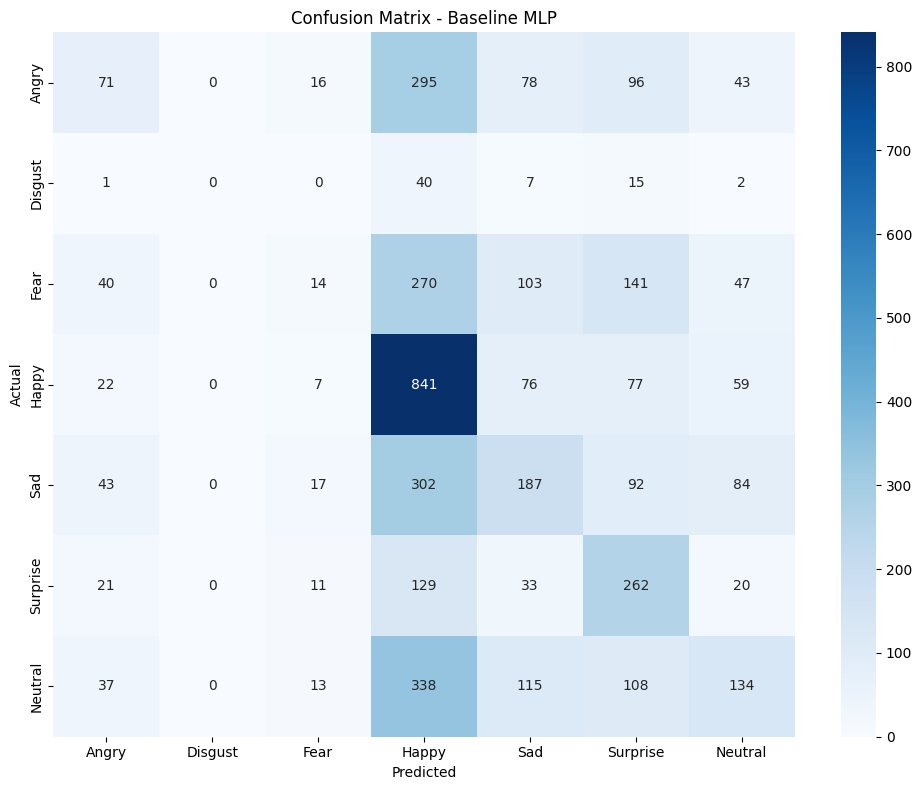

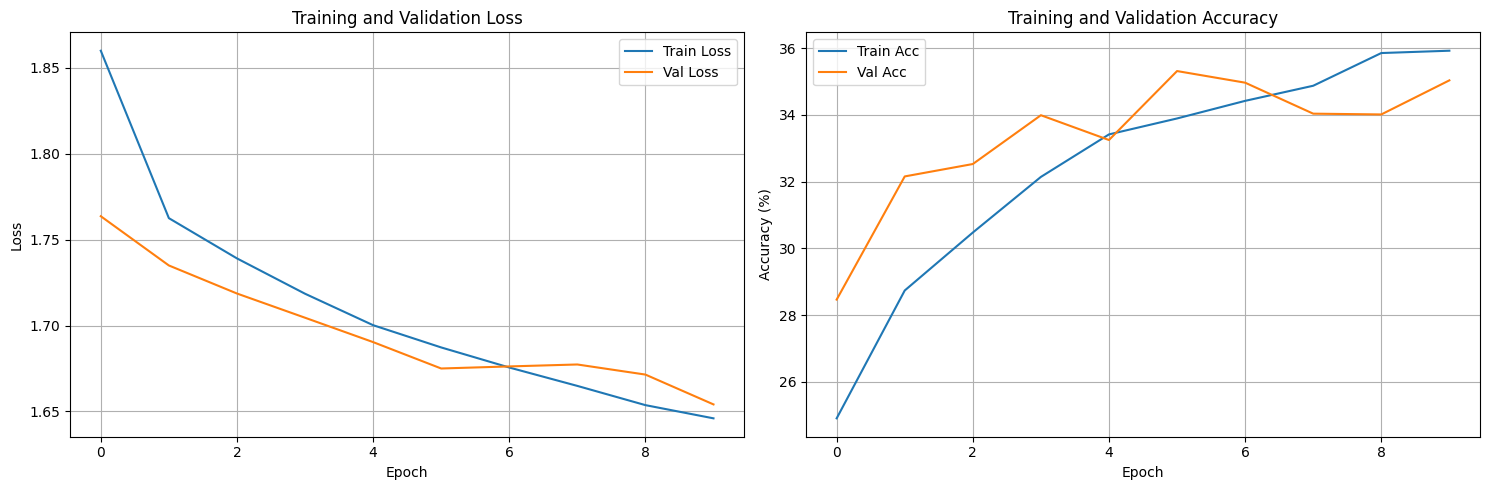

In [29]:
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Baseline MLP')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('baseline_mlp_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(final_history['train_loss'], label='Train Loss')
axes[0].plot(final_history['val_loss'], label='Val Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(final_history['train_acc'], label='Train Acc')
axes[1].plot(final_history['val_acc'], label='Val Acc')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('baseline_mlp_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
print("=== SAVING MODEL PIPELINE ===")

class MLPPipeline:
    def __init__(self, model_state_dict, model_config):
        self.model_config = model_config
        self.emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

        self.model = SimpleMLP(**model_config)
        self.model.load_state_dict(model_state_dict)
        self.model.eval()

    def preprocess(self, pixels_string):
        pixels = np.array([int(p) for p in pixels_string.split()], dtype=np.float32)
        pixels = pixels / 255.0
        return torch.FloatTensor(pixels).unsqueeze(0)

    def predict(self, pixels_string):
        with torch.no_grad():
            input_tensor = self.preprocess(pixels_string)
            output = self.model(input_tensor)
            probabilities = torch.softmax(output, dim=1)
            prediction = torch.argmax(output, dim=1)

            return {
                'predicted_class': int(prediction.item()),
                'predicted_emotion': self.emotion_map[int(prediction.item())],
                'confidence': float(probabilities.max().item()),
                'all_probabilities': {
                    self.emotion_map[i]: float(probabilities[0, i].item())
                    for i in range(7)
                }
            }

model_config = {
    'input_size': 2304,
    'hidden_size': best_config['hidden_size'],
    'num_classes': 7,
    'dropout_rate': best_config['dropout_rate']
}

pipeline = MLPPipeline(final_model.state_dict(), model_config)

os.makedirs('models/saved_pipelines', exist_ok=True)

torch.save({
    'model_state_dict': final_model.state_dict(),
    'model_config': model_config,
    'best_config': best_config,
    'training_history': final_history,
    'validation_accuracy': accuracy,
    'hyperparameter_results': hyperparameter_results,
    'cv_results': {
        'mean_accuracy': mean_cv_acc,
        'std_accuracy': std_cv_acc,
        'individual_folds': cv_accuracies
    },
    'data_split_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'split_method': 'predefined_stratified'
    }
}, 'models/saved_pipelines/baseline_mlp_pipeline.pth')

print("✅ Model pipeline saved successfully!")

test_sample = val_df.iloc[0]['pixels']
test_prediction = pipeline.predict(test_sample)
print(f"\nPipeline test:")
print(f"Predicted emotion: {test_prediction['predicted_emotion']}")
print(f"Confidence: {test_prediction['confidence']:.4f}")

=== SAVING MODEL PIPELINE ===
✅ Model pipeline saved successfully!

Pipeline test:
Predicted emotion: Sad
Confidence: 0.2300


In [31]:
print(f"Final validation accuracy: {accuracy:.4f}")
print(f"Cross-validation accuracy: {mean_cv_acc:.2f} ± {std_cv_acc:.2f}%")
print(f"Test set ({len(test_df)} samples) reserved for final evaluation only!")

Final validation accuracy: 0.3504
Cross-validation accuracy: 33.39 ± 1.14%
Test set (4307 samples) reserved for final evaluation only!
